In [1]:
import sys
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import flopy

exe_name = 'mf6'

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy


## Get the data

Data files of interest in `data/raw/` are called:

1. idomain.dat
2. bottom.dat
3. hk.dat
4. riv.dat
5. wel.dat
6. chd.dat

## Model data

Load ibound data and determine the number of rows and columns in the model.

In [2]:
fpth = 'data/raw/idomain.dat'
idomain = np.loadtxt(fpth, dtype=np.int)

In [3]:
nlay, nrow, ncol = 1, idomain.shape[0], idomain.shape[1]

In [4]:
print(nlay, nrow, ncol)

1 40 20


In [5]:
msize = (nlay, nrow, ncol)
idomain = idomain.reshape(msize)

Load model bottom data

In [6]:
fpth = 'data/raw/bot.dat'
bot = np.loadtxt(fpth, dtype=np.float)
bot = bot.reshape(msize)
bot.shape

(1, 40, 20)

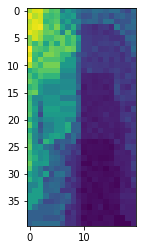

In [7]:
plt.imshow(bot[0, :, :])

Create starting head data and set to $16.9$. Make sure starting head is above the bottom of the model.

In [8]:
strt = np.ones(msize, dtype=np.float) * 16.9

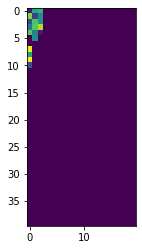

In [9]:
idx = strt < bot
strt[idx] = bot[idx] + 0.1
plt.imshow(strt[0])

Load the hydraulic conductivity

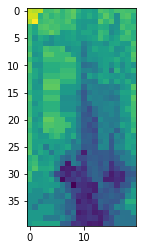

In [10]:
fpth = 'data/raw/hk.dat'
hk = np.loadtxt(fpth, dtype=np.float).reshape(msize)
plt.imshow(hk[0])

## Boundary data

Load the chd data and put it in a list of lists with `[(layer, row, column), head]`.

In [11]:
fpth = 'data/raw/chd.dat'
d = np.loadtxt(fpth, dtype=np.float)
print(d.shape)
print(d)

(10, 4)
[[ 1.  40.   6.  16.9]
 [ 1.  40.   7.  16.4]
 [ 1.  40.   8.  16.1]
 [ 1.  40.   9.  15.6]
 [ 1.  40.  10.  15.1]
 [ 1.  40.  11.  14. ]
 [ 1.  40.  12.  13. ]
 [ 1.  40.  13.  12.5]
 [ 1.  40.  14.  12. ]
 [ 1.  40.  15.  11.4]]


In [12]:
dchd = []
for i in range(d.shape[0]):
    kk, ii, jj = d[i, :3].astype(np.int) - 1
    if idomain[kk, ii, jj] < 1:
        continue
    v = [(kk, ii, jj), d[i, 3]]
    dchd.append(v)
print(dchd)

[[(0, 39, 6), 16.4], [(0, 39, 7), 16.1], [(0, 39, 8), 15.6], [(0, 39, 9), 15.1], [(0, 39, 10), 14.0], [(0, 39, 11), 13.0], [(0, 39, 12), 12.5], [(0, 39, 13), 12.0]]


Load the river data and put it in a list of lists with `[(layer, row, column), stage, cond, rbot]`.

In [13]:
fpth = 'data/raw/riv.dat'
dtype = np.dtype([('k', np.int), ('i', np.int), ('j', np.int), 
                  ('stage', np.float), ('cond', np.float), ('rbot', np.float)])
d = np.loadtxt(fpth, dtype=dtype)
print(d.shape)

(61,)


In [14]:
d['k'] -= 1
d['i'] -= 1
d['j'] -= 1

In [15]:
driv = []
for dd in d:
    v = [(dd['k'], dd['i'], dd['j']), dd['stage'], dd['cond'], dd['rbot']]
    driv.append(v)
print(driv)

[[(0, 0, 13), 20.010714, 0.025578, 19.901585], [(0, 1, 13), 19.828537, 0.027658, 19.700878], [(0, 2, 13), 19.694214, 0.012708, 19.552896], [(0, 2, 14), 19.584358, 0.021429, 19.431868], [(0, 3, 14), 19.424028, 0.029749, 19.255232], [(0, 4, 14), 19.240538, 0.030683, 19.05308], [(0, 5, 14), 19.077934, 0.024551, 18.87394], [(0, 5, 13), 18.937605, 0.024548, 18.719337], [(0, 6, 13), 18.825644, 0.015433, 18.595989], [(0, 6, 12), 18.71987, 0.023227, 18.47946], [(0, 7, 12), 18.56686, 0.033985, 18.310888], [(0, 8, 12), 18.3869, 0.035051, 18.112627], [(0, 8, 13), 18.287588, 0.003672, 18.003216], [(0, 9, 13), 18.178991, 0.039976, 17.883574], [(0, 9, 14), 18.035973, 0.017987, 17.726009], [(0, 10, 14), 17.892506, 0.041968, 17.567953], [(0, 11, 14), 17.701406, 0.039531, 17.357418], [(0, 11, 15), 17.608841, 0.000539, 17.25544], [(0, 12, 15), 17.496944, 0.049333, 17.132162], [(0, 13, 15), 17.348421, 0.017231, 16.968534], [(0, 13, 16), 17.243919, 0.03078, 16.853403], [(0, 14, 15), 17.091406, 0.040485, 1

Load the well data and put it in a list of lists with `[(layer, row, column), q]`.

In [16]:
fpth = 'data/raw/wel.dat'
d = np.loadtxt(fpth, dtype=np.float)

In [17]:
dwel = []
dwelloc = []
for n in range(d.shape[0]):
    k, i, j = d[n, :3].astype(np.int) - 1
    v = [(k, i, j), d[n, 3]]
    dwel.append(v)
    dwelloc.append((k, i, j))
print(dwel)
print(dwelloc)

[[(0, 28, 5), -1.011], [(0, 25, 9), -1.046], [(0, 33, 11), -4.364], [(0, 8, 15), -8.151], [(0, 19, 13), -3.775], [(0, 10, 12), -4.005]]
[(0, 28, 5), (0, 25, 9), (0, 33, 11), (0, 8, 15), (0, 19, 13), (0, 10, 12)]


## Define remaining data

$\Delta x = \Delta y = 250$

Top = $35$

Recharge = $1.6000 \times 10^{-9}$

In [18]:
delr = delc = 250.
top = 35
rch = 1.6e-9

In [19]:
dchd

[[(0, 39, 6), 16.4],
 [(0, 39, 7), 16.1],
 [(0, 39, 8), 15.6],
 [(0, 39, 9), 15.1],
 [(0, 39, 10), 14.0],
 [(0, 39, 11), 13.0],
 [(0, 39, 12), 12.5],
 [(0, 39, 13), 12.0]]

## Create the model

Create a model with 1 steady state-stress period (perlen = 1., nstp=1) and 1 transient stress period (perlen = 3650., nstp = 10). Define the river data in the 1st stress period and define the well data in the 2nd stress period.

The simulation will need a `TDIS6` and a `IMS6` Packages.

A `GWF` model will be added to the simulation file and will need a `DIS`, `IC`, `NPF`, `CHD`, `RIV`, `WEL`, `RCH`,  and `OC` Package. The `RCH` file can either be a list- or array-based Package.

List-based boundary conditions are created as dictionaries. The well package stress period data can be created for stress period 2 as `stress_period_data = {1: wel}`.

Save binary head and budget output every time step.

Set the model workspace to `'work/ex05a'`.

In [20]:
# Create the Flopy simulation object
name = 'mymodel1'
ws = 'work/ex05a'
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name=exe_name, 
                             version='mf6', sim_ws=ws)

# Create the Flopy temporal discretization object
perioddata = [(1., 1, 1.), (3650., 10, 1.)]
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, time_units='DAYS', nper=2, 
                                            perioddata=perioddata)
flopy.__version__

'3.3.0'

In [21]:
# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.MFModel(sim, model_type='gwf6', modelname=name, 
                        model_nam_file=model_nam_file)

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, complexity='SIMPLE')

In [22]:
# Create the discretization package
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                               delr=delr, delc=delc, top=top,
                                               botm=bot, idomain=idomain)

In [23]:
# Create the initial conditions package
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, strt=strt)

In [24]:
# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, icelltype=1, k=hk,
                                               save_flows=True, save_specific_discharge=True)

In [ ]:
# storage package
sto = flopy.mf6.ModflowGwfsto(gwf, save_flows=True, iconvert=1, ss=1e-6, 
                              sy=0.2, steady_state={0:True},
                              transient={1:True})

In [ ]:
# Create the constant head package.
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, maxbound=len(dchd), 
                                               stress_period_data=dchd, save_flows=True)

In [ ]:
# wel package
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True, print_flows=True, maxbound=len(dwel),
                              stress_period_data={1: dwel}, 
                              save_flows=True)

In [ ]:
# river package
riv = flopy.mf6.ModflowGwfriv(gwf, print_input=True, print_flows=True,
                              maxbound=len(driv), stress_period_data=driv)

In [ ]:
# recharge package
rch1 = flopy.mf6.ModflowGwfrcha(gwf, recharge=rch, print_input=True)

In [ ]:
# Create the output control package
headfile = '{}.hds'.format(name)
head_filerecord = [headfile]
budgetfile = '{}.cbb'.format(name)
budget_filerecord = [budgetfile]
saverecord = [('HEAD', 'ALL'), 
              ('BUDGET', 'ALL')]
printrecord = [('HEAD', 'LAST')]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, saverecord=saverecord, 
                                            head_filerecord=head_filerecord,
                                            budget_filerecord=budget_filerecord,
                                            printrecord=printrecord)

In [ ]:
# write simulation to new location
sim.write_simulation()

## Run the model

In [ ]:
success, buff = sim.run_simulation()
print('\nSuccess is: ', success)

## Plot the head data

`PlotMapView` can be used to plot the head data on the model grid.

In [ ]:
fpth = ws + '/mymodel1.hds'
hobj = flopy.utils.HeadFile(fpth)
kstpkper = hobj.get_kstpkper()
kstpkper
dpos = kstpkper[-1]

In [ ]:
h = hobj.get_data(kstpkper=dpos)

In [ ]:
mm = flopy.plot.PlotMapView(model=gwf)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(5)
ax = plt.gca()
ax.set_xlim(0, 5000)
ax.set_ylim(0, 10000)
mm.plot_array(h, masked_values=[1e30, -1e30])
c = mm.contour_array(h, masked_values=[1e30, -1e30], colors='black',
                     levels=np.arange(0, 40, 5))
plt.clabel(c)
mm.plot_ibound(ibound=idomain)

## Get cell-by cell data

Get cell-by-cell data and use ModelMap to plot heads and vectors on a plot. See flopy github site for the ModelMap example notebook to find code to plot flow vectors.

In [ ]:
fpth = ws + '/mymodel1.cbb'
cobj = flopy.utils.CellBudgetFile(fpth, precision='double')
#cobj.list_records()

In [ ]:
ra = cobj.get_data(kstpkper=dpos, text='DATA-SPDIS')[0]

In [ ]:
mm = flopy.plot.PlotMapView(model=gwf)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(5)
ax = plt.gca()
ax.set_xlim(0, 5000)
ax.set_ylim(0, 10000)
mm.plot_array(h, masked_values=[1e30, -1e30])
c = mm.contour_array(h, masked_values=[1e30, -1e30], colors='black',
                     levels=np.arange(0, 40, 5))
plt.clabel(c)
mm.plot_ibound(ibound=idomain)
mm.plot_specific_discharge(ra);

## Plot a time series at one of the well locations

Use `.get_ts()` to get a time series of water levels at one of the pumping well locations.

In [ ]:
hwells = hobj.get_ts(dwelloc)
plt.plot(hwells[:, 0], hwells[:, 1:])
plt.legend(dwelloc)
#print(hwells)

## Use flopy to evalute how hydraulic conductivity affects results

Wrap the model in a function and call the function in a loop to see how hydraulic conductivity affects water levels at one of the pumping well locations. Think about plotting the mean water level at the observation location.

Set the model workspace to `'work/ex05b'`.

In [ ]:
def make_hkmodel(kmult=1., loc=(0, 28, 5)):
    # Create the Flopy simulation object
    name = 'hkmodel'
    ws = 'work/ex05b'
    sim = flopy.mf6.MFSimulation(sim_name=name, exe_name=exe_name, 
                                 version='mf6', sim_ws=ws)

    # Create the Flopy temporal discretization object
    perioddata = [(1., 1, 1.), (3650., 10, 1.)]
    tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, time_units='DAYS', nper=2, 
                                                    perioddata=perioddata)    

    # Create the Flopy groundwater flow (gwf) model object
    model_nam_file = '{}.nam'.format(name)
    gwf = flopy.mf6.MFModel(sim, model_type='gwf6', modelname=name, 
                            model_nam_file=model_nam_file)

    # Create the Flopy iterative model solver (ims) Package object
    ims = flopy.mf6.modflow.mfims.ModflowIms(sim, complexity='MODERATE')  

    # Create the discretization package
    dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                                   delr=delr, delc=delc, top=top,
                                                   botm=bot, idomain=idomain)
    # Create the initial conditions package
    ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, strt=strt)    

    # Create the node property flow package
    npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, icelltype=1, k=hk*kmult,
                                                   save_flows=True, 
                                                   save_specific_discharge=True)    
    
    # storage package
    sto = flopy.mf6.ModflowGwfsto(gwf, save_flows=True, iconvert=1, ss=1e-6, 
                                  sy=0.2, steady_state={0:True},
                                  transient={1:True})    
    
    # Create the constant head package.
    chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, maxbound=len(dchd), 
                                                   stress_period_data=dchd, save_flows=True)    
    
    # wel package
    wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True, print_flows=True, maxbound=len(dwel),
                                  stress_period_data={1: dwel}, 
                                  save_flows=True)
    
    # river package
    riv = flopy.mf6.ModflowGwfriv(gwf, print_input=True, print_flows=True,
                                  maxbound=len(driv), stress_period_data=driv)    
    
    # recharge package
    rch1 = flopy.mf6.ModflowGwfrcha(gwf, recharge=rch, print_input=True)
    
    # Create the output control package
    headfile = '{}.hds'.format(name)
    head_filerecord = [headfile]
    budgetfile = '{}.cbb'.format(name)
    budget_filerecord = [budgetfile]
    saverecord = [('HEAD', 'ALL'), 
                  ('BUDGET', 'ALL')]
    printrecord = [('HEAD', 'LAST')]
    oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, saverecord=saverecord, 
                                                head_filerecord=head_filerecord,
                                                budget_filerecord=budget_filerecord,
                                                printrecord=printrecord)  
    # write simulation to new location
    sim.write_simulation(silent=True)

    # run the model
    success, buff = sim.run_simulation(silent=True)
    if not success:
        print('kmult "{}" model did not terminate successfully'.format(kmult))
    
    # post-process the results
    fpth = ws + '/{}.hds'.format(name)
    hobj = flopy.utils.HeadFile(fpth)
    hwells = hobj.get_ts(dwelloc)
    
    return hwells[:, 0], hwells[:, 1:]

In [ ]:
kmult = np.power(10, np.linspace(-1, 1, num=50))
hmean = []
for kk in kmult:
    t, h = make_hkmodel(kmult=kk, loc=dwelloc)
    idx = (h == -1e30) | (h == 1e30)
    h[idx] = np.nan
    v = []
    for i in range(h.shape[1]):
        v.append(h[:, i].mean())
    hmean.append(v)

In [ ]:
plt.semilogx(kmult, hmean)
plt.legend(dwelloc)  
plt.xlabel('Hydraulic conductivity multipler')
plt.ylabel('Mean simulated head')

## Use flopy to create a multi-layer model

Split the model into three-layers (it is probably easier to recreate the entire model). Turn on the newton-raphson formulation in the `GWF` model and use `BICGSTAB` linear acceleration in the `IMS6` file. Plot the results.

Set the model workspace to `'work/ex05c'`.

In [ ]:
nlay = 3

In [ ]:
# use the same idomain value in each layer
fpth = 'data/raw/idomain.dat'
idomain = np.loadtxt(fpth, dtype=np.int)
idomain = [idomain for i in range(nlay)]

In [ ]:
# calculate the dz for each layer calculated using top and botm
top = np.ones((nrow, ncol), dtype=np.float) * 35.
fpth = 'data/raw/bot.dat'
bot = np.loadtxt(fpth, dtype=np.float)
print(bot.shape, bot.min(), bot.max(), bot.mean())
dz = (top - bot) / float(nlay)
print(dz.min(), dz.mean(), bot.min(), bot.max())
bot = [top - dz * float(i+1) for i in range(nlay)]

In [ ]:
# use the same starting head in each layer
strt = np.ones((nrow, ncol), dtype=np.float)
idx = strt < bot[-1]
strt[idx] =  bot[-1][idx] + 0.1
strt = [strt for i in range(nlay)]

In [ ]:
# use same hk value in each layer
fpth = 'data/raw/hk.dat'
hk = np.loadtxt(fpth, dtype=np.float)
hk = [hk for i in range(nlay)]

In [ ]:
# need to move the pumpage to layer 3
fpth = 'data/raw/wel.dat'
d = np.loadtxt(fpth, dtype=np.float)
dwel = []
dwelloc = []
for n in range(d.shape[0]):
    k, i, j = d[n, :3].astype(np.int) - 1
    v = [(2, i, j), d[n, 3]]
    dwel.append(v)
    dwelloc.append((2, i, j))
print(dwel)
print(dwelloc)

In [ ]:
# need to make sure that chd is in a cell with the bottom of the layer below the specified head
fpth = 'data/raw/chd.dat'
d = np.loadtxt(fpth, dtype=np.float)
dchd = []
for n in range(d.shape[0]):
    k, i, j = d[n, :3].astype(np.int) - 1
    if idomain[k][i, j] < 1:
        continue
    chd = d[n, 3]
    botn = bot[k][i, j]
    if chd < botn:
        for kk in range(1, nlay):
            botn2 = bot[kk][i, j]
            if botn2 < chd:
                k = kk
                break
    v = [(k, i, j), chd]
    dchd.append(v)
print(dchd)

In [ ]:
# need to make sure that river is in a cell with the bottom of the layer below the specified rbot
fpth = 'data/raw/riv.dat'
dtype = np.dtype([('k', np.int), ('i', np.int), ('j', np.int), 
                  ('stage', np.float), ('cond', np.float), ('rbot', np.float)])
d = np.loadtxt(fpth, dtype=dtype)
driv = []
d['k'] -= 1
d['i'] -= 1
d['j'] -= 1
for dd in d:
    k, i, j = dd['k'], dd['i'], dd['j']
    rbot = dd['rbot']
    botn = bot[k][i, j]
    #print(1, rbot, botn)
    if rbot < botn:
        for kk in range(1, nlay):
            botn2 = bot[kk][i, j]
            #print(kk+1, rbot, botn2)
            if botn2 < rbot:
                #print('-', rbot, botn2)
                k = kk
                break
    v = [(k, i, j), dd['stage'], dd['cond'], rbot]
    driv.append(v)
print(driv)

In [ ]:
# Create the Flopy simulation object
name = 'threelayermodel'
exe_name = 'mf6'
ws = 'work/ex05c'
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name=exe_name, 
                             version='mf6', sim_ws=ws)

# Create the Flopy temporal discretization object
perioddata = [(1., 1, 1.), (3650., 10, 1.)]
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, time_units='DAYS', nper=2, 
                                                perioddata=perioddata)    

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.MFModel(sim, model_type='gwf6', modelname=name, 
                        model_nam_file=model_nam_file)
# turn on Newton-Rephson
gwf.name_file.newtonoptions = ('')

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, complexity='COMPLEX')  

# Create the discretization package
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                               delr=delr, delc=delc, top=top,
                                               botm=bot, idomain=idomain)
# Create the initial conditions package
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, strt=strt)    

# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, icelltype=1, k=hk,
                                               save_flows=True, save_specific_discharge=True)    

# storage package
sto = flopy.mf6.ModflowGwfsto(gwf, save_flows=True, iconvert=1, ss=1e-6, 
                              sy=0.2, steady_state={0:True},
                              transient={1:True})    

# Create the constant head package.
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, maxbound=len(dchd), 
                                               stress_period_data=dchd, save_flows=True)    

# wel package
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True, print_flows=True, maxbound=len(dwel),
                              stress_period_data={1: dwel}, 
                              save_flows=True)

# river package
riv = flopy.mf6.ModflowGwfriv(gwf, print_input=True, print_flows=True,
                              maxbound=len(driv), stress_period_data=driv)    

# recharge package
rch1 = flopy.mf6.ModflowGwfrcha(gwf, recharge=rch, print_input=True)

# Create the output control package
headfile = '{}.hds'.format(name)
head_filerecord = [headfile]
budgetfile = '{}.cbb'.format(name)
budget_filerecord = [budgetfile]
saverecord = [('HEAD', 'ALL'), 
              ('BUDGET', 'ALL')]
printrecord = [('HEAD', 'LAST')]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, saverecord=saverecord, 
                                            head_filerecord=head_filerecord,
                                            budget_filerecord=budget_filerecord,
                                            printrecord=printrecord)  
# write simulation to new location
sim.write_simulation()

# run the model
success, buff = sim.run_simulation()
if not success:
    print('model did not terminate successfully')

In [ ]:
fpth = ws + '/{}.hds'.format(name)
hobj = flopy.utils.HeadFile(fpth)
kstpkper = hobj.get_kstpkper()
dpos = kstpkper[-1]
h = hobj.get_data(kstpkper=dpos)

In [ ]:
fpth = ws + '/{}.cbb'.format(name)
cobj = flopy.utils.CellBudgetFile(fpth, precision='double')
ra = cobj.get_data(kstpkper=dpos, text='DATA-SPDIS')[0]

In [ ]:
fig, axes = plt.subplots(ncols=nlay, nrows=1, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)
for k, ax in enumerate(axes.flatten()):
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=k)
    ax.set_title('Layer {}'.format(k+1))
    ax.set_aspect('equal')
    ax.set_xlim(0, 5000)
    ax.set_ylim(0, 10000)
    mm.plot_array(h, masked_values=[1e30, -1e30])
    c = mm.contour_array(h, masked_values=[1e30, -1e30], colors='black', 
                         levels=np.arange(0, 40, 5))
    plt.clabel(c)
    mm.plot_ibound(ibound=np.array(idomain))
    mm.plot_specific_discharge(ra);